# Preprocessing

For now we need just pandas for parsing dataset and transformers for BERT

In [180]:
# !conda update nbformat -y #AWS related package
!pip install transformers
import pandas as pd
from transformers import *
import numpy as np
import torch
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


Read excel file, skip headers and 1st row with column nasmes

In [0]:
df= pd.read_excel('dataset.xlsx', header=None, skiprows=1)
pdf = pd.read_excel('dataset.xlsx', header=None, skiprows=1)
pdf.drop(pdf[pdf[23] == 'nie dotyczy'].index, inplace=True)
pdf = pdf.reset_index()

For our smaller version of dataset just take two features that we are interested in, namely T PL and GOLD<T,H>

In [0]:
dataset = df[[4, 5]]

Dataset which includes presupposition

In [183]:
presup_dataset = pdf[[4,5,23]]
presup_dataset.head

<bound method NDFrame.head of                                                     4  5    23
0           Ani że na progu stanął właśnie Romanyczko.  ?   no
1    Zresztą, w celi wcale nie czuło się, że jest maj.  E  yes
2         Czuł, że maszynistka nie spuszczają zeń oczu  E  yes
3    Trochę po północy ksiądz Suryn obudził się gwa...  E  yes
4    Biorąc pod uwagę, że grunty pod park nie są je...  E  yes
..                                                 ... ..  ...
760  Patrząc na fundamenty podtopionych budynków pa...  E  yes
761  Widać było, że nie ustoi, że jak badyl złamany...  E  yes
762  Widać było, że nie ustoi, że jak badyl złamany...  E  yes
763            Widać, że jest już na ostatnich nogach.  E  yes
764  Tu będą mogli zobaczyć, że Państwo Izrael ma k...  E  yes

[765 rows x 3 columns]>

In [184]:
dataset.head

<bound method NDFrame.head of                                                       4  5
0     Ja na to, że mam klasówkę, że zawalę biologię ...  N
1            Ani że na progu stanął właśnie Romanyczko.  ?
2                  Potem, że się przywiezie Chińczyków.  N
3     Słabł coraz bardziej, czuł, że to kwestia zale...  N
4     Jednak ludzie bardzo ciężko chorzy, gdy już cz...  N
...                                                 ... ..
2591  Udało się ustalić, że obie dziewczynki mogą pr...  N
2592  Ustalono, że łączą go z niektórymi członkami g...  N
2593  Tu będą mogli zobaczyć, że Państwo Izrael ma k...  E
2594  Oczywiście, że można kochać, jeśli zobaczy się...  N
2595  Oczywiście, że można kochać, jeśli zobaczy się...  N

[2596 rows x 2 columns]>

Graphical representation of dataset

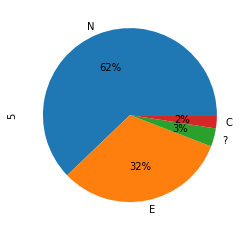

In [185]:
dataset[5].value_counts().plot(kind='pie', autopct='%1.0f%%')

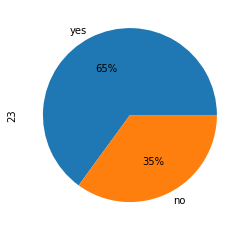

In [186]:
presup_dataset[23].value_counts().plot(kind='pie', autopct='%1.0f%%')

Change labels of ECN for numeric values

In [0]:
labels = {'E':0,'C':1,'N':2,'?':3}

for idx, row in dataset.iterrows():
    row[5] = labels[row[5]]

In [188]:
dataset

,4,5
0,"Ja na to, że mam klasówkę, że zawalę biologię ...",2
1,Ani że na progu stanął właśnie Romanyczko.,3
2,"Potem, że się przywiezie Chińczyków.",2
3,"Słabł coraz bardziej, czuł, że to kwestia zale...",2
4,"Jednak ludzie bardzo ciężko chorzy, gdy już cz...",2
...,...,...
2591,"Udało się ustalić, że obie dziewczynki mogą pr...",2
2592,"Ustalono, że łączą go z niektórymi członkami g...",2
2593,"Tu będą mogli zobaczyć, że Państwo Izrael ma k...",0
2594,"Oczywiście, że można kochać, jeśli zobaczy się...",2


In [189]:
presup_labels = {'yes':1, 'no':0}
for idx,row in presup_dataset.iterrows():
  row[23] = presup_labels[row[23]]
  row[5] = labels[row[5]]
presup_dataset

,4,5,23
0,Ani że na progu stanął właśnie Romanyczko.,3,0
1,"Zresztą, w celi wcale nie czuło się, że jest maj.",0,1
2,"Czuł, że maszynistka nie spuszczają zeń oczu",0,1
3,Trochę po północy ksiądz Suryn obudził się gwa...,0,1
4,"Biorąc pod uwagę, że grunty pod park nie są je...",0,1
...,...,...,...
760,Patrząc na fundamenty podtopionych budynków pa...,0,1
761,"Widać było, że nie ustoi, że jak badyl złamany...",0,1
762,"Widać było, że nie ustoi, że jak badyl złamany...",0,1
763,"Widać, że jest już na ostatnich nogach.",0,1


Finding longest sentence for future padding

In [190]:
max_len = 0
m_idx = 0
for idx,row in dataset.iterrows():
    l = len(row[4])
    if l > max_len:
        max_len = l
        m_idx = idx
print(m_idx)

360


In [191]:
print(dataset[4][m_idx])

Ci z koalicji rządzącej, ci posłowie, którzy w trakcie posiedzenia sejmowej Komisji Polityki Gospodarczej, Budżetu i Finansów z uporem, myślę, godnym lepszej sprawy, bronili faktu, aby rząd łącznie z budżetem - zapowiadam, łącznie z budżetem, bo mamy świadomość, że nie było i nie ma czasu na to, żeby wcześniej rozpatrywać założenia, a potem przedkładać budżet - przedłożył założenia polityki społeczno-gospodarczej, jako dokumentu ujmującego tę politykę w dłuższym czasie, posłowie, którzy nie dopuścili do takiego rozstrzygnięcia - przypominam, tylko jednym głosem - źle służą również rządowi.


In [192]:
!pip install sklearn
from sklearn.model_selection import train_test_split

# Polbert

Here we import pretrained version of Bert for Polish language

In [0]:
model_class, tokenizer_class, pretrained_weights = (BertModel, BertTokenizer, "dkleczek/bert-base-polish-uncased-v1")

model = model_class.from_pretrained(pretrained_weights)
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

## Tokenization

Tokenize every sentence from our dataset

In [0]:
tokenized = dataset[4].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
presup_tokenized = presup_dataset[4].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Values from tokenization

In [195]:
tokenized.values

array([list([2, 2055, 1898, 1907, 16, 2095, 2040, 15701, 1889, 3118, 16, 2095, 32091, 1014, 12071, 1014, 51, 1893, 15887, 1012, 1906, 27508, 2165, 4785, 18, 4]),
       list([2, 2937, 2095, 1898, 26468, 40126, 1019, 29480, 6977, 1013, 7150, 18, 4]),
       list([2, 3006, 16, 2095, 2243, 11319, 2713, 11007, 8572, 1889, 18, 4]),
       ...,
       list([2, 2030, 40221, 4949, 38584, 16, 2095, 2013, 2803, 12250, 1994, 26825, 2437, 48721, 16, 2030, 14229, 2114, 2808, 21694, 40575, 4955, 52867, 9417, 16, 2030, 8822, 1948, 2243, 24391, 3117, 4955, 52867, 1014, 27972, 16, 2030, 48570, 41886, 2243, 51, 5245, 50930, 36755, 50719, 15956, 23652, 2054, 18, 4]),
       list([2, 31040, 16, 2095, 29801, 6289, 1015, 16, 10865, 3403, 2243, 16, 2095, 2259, 16879, 1015, 1893, 40065, 1923, 2243, 68, 4109, 16, 2095, 2499, 3089, 1906, 3115, 3410, 18, 4]),
       list([2, 31040, 16, 2095, 29801, 6289, 1015, 16, 10865, 3403, 2243, 16, 2095, 2259, 16879, 1015, 1893, 40065, 1923, 2243, 68, 4109, 16, 2095, 2499, 

In [260]:
presup_tokenized.values[:10]

array([list([2, 2937, 2095, 1898, 26468, 40126, 1019, 29480, 6977, 1013, 7150, 18, 4]),
       list([2, 4309, 29850, 16, 65, 11409, 4771, 1893, 11981, 1005, 2243, 16, 2095, 1919, 3623, 18, 4]),
       list([2, 11981, 16, 2095, 9073, 6798, 1922, 1893, 52102, 1008, 26246, 9325, 4]),
       list([2, 15556, 1896, 3949, 53023, 1013, 41502, 1899, 7970, 12191, 21635, 2243, 28984, 16, 1951, 1961, 35387, 15075, 1895, 16, 51, 3241, 22237, 16, 2095, 8182, 22566, 1892, 2243, 65, 2524, 5261, 16, 2095, 3869, 3430, 26716, 1013, 50590, 1013, 58461, 7518, 7295, 25607, 51, 2095, 1898, 14486, 1919, 34252, 3415, 16, 38053, 31135, 41262, 2203, 2243, 2114, 2840, 18, 4]),
       list([2, 5412, 16609, 2011, 14997, 1014, 16, 2095, 45544, 2011, 5780, 1893, 3003, 2286, 10997, 25092, 16, 10367, 38185, 52421, 3234, 5533, 4471, 31435, 1927, 17, 15469, 12292, 35663, 23260, 1905, 8668, 18, 4]),
       list([2, 5412, 16609, 2011, 14997, 1014, 16, 2095, 2150, 65, 39130, 16, 1907, 2216, 59377, 16, 2095, 2303, 1937, 1351

## Padding

We need to have input of the same lenght in order to feed BERT once (we will get performance speed). This will be some simple python string manipulation

In [0]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [198]:
max_len

146

In [199]:
presup_max_len = 0
for i in presup_tokenized.values:
  if len(i) > presup_max_len:
    presup_max_len = len(i)
presup_max_len

108

Maybe we can consider shortening some sentences here

In [0]:
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
presup_padded = np.array([i + [0]*(presup_max_len-len(i)) for i in presup_tokenized.values])

Padded tokenized values looks as follow

In [201]:
padded

array([[    2,  2055,  1898, ...,     0,     0,     0],
       [    2,  2937,  2095, ...,     0,     0,     0],
       [    2,  3006,    16, ...,     0,     0,     0],
       ...,
       [    2,  2030, 40221, ...,     0,     0,     0],
       [    2, 31040,    16, ...,     0,     0,     0],
       [    2, 31040,    16, ...,     0,     0,     0]])

In [202]:
presup_padded

array([[    2,  2937,  2095, ...,     0,     0,     0],
       [    2,  4309, 29850, ...,     0,     0,     0],
       [    2, 11981,    16, ...,     0,     0,     0],
       ...,
       [    2,  9898, 16609, ...,     0,     0,     0],
       [    2,  9898, 16609, ...,     0,     0,     0],
       [    2,  2030, 40221, ...,     0,     0,     0]])

In [203]:
np.array(padded).shape

(2596, 146)

## Computing embedding using BERT

Now we do create cube of 146(tokens per row) * 768 (hidden layers) * 2596 (number of sentences)

In [0]:
input_ids = torch.tensor(np.array(padded))

In [205]:
input_ids

tensor([[    2,  2055,  1898,  ...,     0,     0,     0],
        [    2,  2937,  2095,  ...,     0,     0,     0],
        [    2,  3006,    16,  ...,     0,     0,     0],
        ...,
        [    2,  2030, 40221,  ...,     0,     0,     0],
        [    2, 31040,    16,  ...,     0,     0,     0],
        [    2, 31040,    16,  ...,     0,     0,     0]])

In [206]:
input_ids.shape

torch.Size([2596, 146])

Here we compute embeddings for our tokenized values. It is the longest time consuming operation in this notebook, can take approximately up to 10 minutes

In [0]:
with torch.no_grad():
    last_hidden_states = model(input_ids)

We will extract two sets of embeddings. One for CSL only (2D array) and one for the whole cube

In [0]:
features = last_hidden_states[0][:,:,:].numpy()

In [209]:
cls_features = last_hidden_states[0][:,0,:].numpy()
cls_features

array([[ 0.25127047,  0.05621039,  0.5283817 , ..., -0.16011767,
         0.09001464, -0.38211265],
       [ 0.42232475,  0.08961002,  0.49109307, ..., -0.20376782,
        -0.16197048, -0.5356227 ],
       [ 0.50437593,  0.01179665,  0.48297465, ..., -0.11081177,
        -0.09251087, -0.42476308],
       ...,
       [ 0.24305844, -0.14591762,  0.9826037 , ...,  0.15874851,
         0.02587719, -0.27605474],
       [ 0.19790465, -0.05286083,  0.54641706, ..., -0.07265625,
         0.03099446, -0.33454126],
       [ 0.19790465, -0.05286083,  0.54641706, ..., -0.07265625,
         0.03099446, -0.33454126]], dtype=float32)

In [210]:
features.shape

(2596, 146, 768)

In [211]:
cls_features.shape

(2596, 768)

## Onehot encoding

In [212]:
y = np.array(dataset[5], dtype=np.int16)
y_labels = np.zeros((y.size, y.max()+1))
y_labels[np.arange(y.size),y] = 1
y_labels

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

## Feed Forward Neural Network
Creating Feed Forward Neural Network which will take as an input vector of embeddings and return one of semantic classes. Firstly we will do it for 2d CLS matrix

In [0]:
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as ds
import torch.nn.functional as F
import time

### Creating dataset

In [214]:
train_features, test_features, train_labels, test_labels = train_test_split(cls_features, y)
train_features[:10]

array([[ 0.7036125 , -0.21495306,  0.7767872 , ..., -0.30695572,
        -0.28999647, -0.7216592 ],
       [ 0.13759235, -0.01129367,  0.60140604, ..., -0.06906768,
         0.1671999 , -0.27325547],
       [ 0.05100797,  0.09301066,  0.7130889 , ..., -0.3162811 ,
         0.560127  , -0.3455388 ],
       ...,
       [ 0.24265398,  0.14142074,  0.70771456, ..., -0.0333265 ,
         0.0443786 , -0.15903404],
       [ 0.29462156, -0.02298697,  0.8642586 , ..., -0.07703716,
        -0.00921529, -0.3532715 ],
       [ 0.21536855, -0.10234317,  0.7758023 , ..., -0.3234807 ,
         0.04727036, -0.26320168]], dtype=float32)

## Convert data to Torch tensor

In [0]:
train_features = torch.from_numpy(train_features)
test_features = torch.from_numpy(test_features)
train_labels = torch.from_numpy(train_labels)
test_labels = torch.from_numpy(test_labels)

In [216]:
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

torch.Size([1947, 768])
torch.Size([649, 768])
torch.Size([1947])
torch.Size([649])


In [217]:
batch_size = int(train_features.shape[0] / 50)
batch_size

38

Here we define class of our neural network. It will be simple FFNN, which uses RELu for activation and softmax for squashing

In [0]:
class FeedforwardNeuralNetModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(FeedforwardNeuralNetModel, self).__init__()
    self.input_size = input_size
    self.hidden_size  = hidden_size
    self.output_zise = output_size
    self.fc1 = nn.Linear(self.input_size, self.hidden_size)
    self.fc2 = nn.Linear(hidden_size,hidden_size)
    self.fc3 = nn.Linear(self.hidden_size, output_size)


  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    output = self.fc3(x)
    return F.log_softmax(output, dim=0)

Here we define some parameters for the NN

In [219]:
tokens = 1
input_dim = 768 * tokens
hidden_dim = 256
output_dim = len(labels)

input_dim

768

In [0]:
ffnn = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

As a loss criterion we will use CrossEntropyLoss

In [0]:
criterion = nn.CrossEntropyLoss()

In [222]:
print(ffnn)

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)


In [0]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [230]:
train_losses = []
ffnn = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
learning_rate = 0.00001
optimizer = torch.optim.Adam(ffnn.parameters(), lr=learning_rate)

for epoch in range(0,151):
    
    ffnn.train(True)
    train_loss = 0 

    for x_batch, y_batch, batch in generate_batch_data(train_features, train_labels, batch_size):
        optimizer.zero_grad()
        y_pred = ffnn(x_batch)
        loss = criterion(y_pred, y_batch.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    if epoch % 5 == 0:
      train_losses.append(train_loss/len(train_features))
      print(f"{epoch} / 150 | loss = {train_loss/len(train_features)}")






0 / 150 | loss = 0.036980828506614716
5 / 150 | loss = 0.036776336572938044
10 / 150 | loss = 0.03651312001252333
15 / 150 | loss = 0.03603161575246849
20 / 150 | loss = 0.03441241783059801
25 / 150 | loss = 0.028968967103198913
30 / 150 | loss = 0.02513042865316257
35 / 150 | loss = 0.02373676099223728
40 / 150 | loss = 0.023038911862317022
45 / 150 | loss = 0.022575266004894474
50 / 150 | loss = 0.022220932953652812
55 / 150 | loss = 0.021924876132008966
60 / 150 | loss = 0.021664412237768854
65 / 150 | loss = 0.021428319234754956
70 / 150 | loss = 0.021212273214680142
75 / 150 | loss = 0.021011820972792358
80 / 150 | loss = 0.020823626761321355
85 / 150 | loss = 0.020645480019408247
90 / 150 | loss = 0.02047396540396876
95 / 150 | loss = 0.020309627331644067
100 / 150 | loss = 0.02015300281058842
105 / 150 | loss = 0.020001420591449395
110 / 150 | loss = 0.019854948697606907
115 / 150 | loss = 0.019710772455075368
120 / 150 | loss = 0.01957205233355945
125 / 150 | loss = 0.019437075

Text(0.5, 1.0, 'Losses')

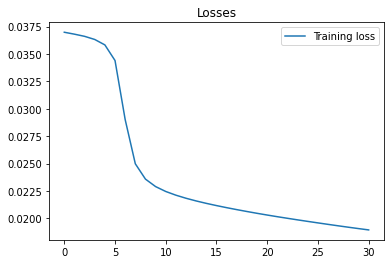

In [225]:
plt.plot(train_losses, label="Training loss")
plt.legend()
plt.title("Losses")

In [252]:
test_losses = []

for epoch in range(0,101):
    
    test_loss = 0 
    correct = 0
    ffnn.eval()

    for x_batch, y_batch, batch in generate_batch_data(test_features, test_labels, batch_size):
        y_pred = ffnn(x_batch)
        loss = criterion(y_pred, y_batch.long())
        pred = np.argmax(y_pred.data,axis=1)
        test_loss += loss.item()
        correct += pred.eq(y_batch.data).sum()

    if epoch % 5 == 0:
      test_losses.append(test_loss/len(test_features))

      print(f"{epoch} / 100 | loss = {test_loss/len(test_features)} | Accuracy = {100. * correct/len(test_features)}%")

0 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
5 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
10 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
15 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
20 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
25 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
30 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
35 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
40 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
45 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
50 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
55 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
60 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
65 / 100 | loss = 0.34688631095923483 | Accuracy = 63.54166793823242%
70 / 100 | loss = 0.34

### 7 times cross-validation

In [226]:
!pip install skorch

from skorch import NeuralNetClassifier
from sklearn.model_selection import cross_val_score

In [253]:
classifier = NeuralNetClassifier(module= ffnn, criterion= nn.CrossEntropyLoss, max_epochs = 100)
scores = cross_val_score(classifier, cls_features, y.astype(int), cv=7)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7982       0.8626        0.6126  0.0327
      2        1.2447       0.8779        0.5945  0.0323
      3        1.1864       0.8626        0.6213  0.0305
      4        1.0882       0.8092        0.6804  0.0310
      5        1.1322       0.8015        0.7587  0.0317
      6        1.0706       0.7786        0.8487  0.0299
      7        1.2305       0.7252        1.0709  0.0278
      8        1.1895       0.7786        0.8142  0.0284
      9        1.0068       0.8015        0.7452  0.0311
     10        1.0151       0.7786        0.8190  0.0329
     11        0.9608       0.8244        0.6727  0.0328
     12        0.9610       0.7786        0.7986  0.0333
     13        0.8731       0.8473        0.5999  0.0325
     14        0.8752       0.7786        0.7797  0.0280
     15        0.8231       0.8550        0.5742  0.0259
     16        0.8186       0.7

# Presupperposition

## Compute BERT embeddings again

In [236]:
input_ids = torch.tensor(np.array(presup_padded))
input_ids.shape
with torch.no_grad():
    last_hidden_states = model(input_ids)
features = last_hidden_states[0][:,:,:].numpy()
cls_features = last_hidden_states[0][:,0,:].numpy()
cls_features

array([[ 0.42202097,  0.02268753,  0.53699994, ..., -0.21211348,
         0.06441058, -0.4888024 ],
       [ 0.33169028, -0.10472161,  0.8189769 , ..., -0.3639792 ,
         0.11494139, -0.38675058],
       [ 0.35144442, -0.06816334,  0.9282086 , ..., -0.30233556,
        -0.20365594, -0.6276086 ],
       ...,
       [ 0.3651335 , -0.09129231,  0.5623702 , ..., -0.15368372,
         0.215161  , -0.27237758],
       [ 0.65971494, -0.13337831,  0.5392584 , ..., -0.25120956,
         0.24526614, -0.5249608 ],
       [ 0.0845321 , -0.20293339,  1.1157786 , ...,  0.1046489 ,
         0.2794116 , -0.29502675]], dtype=float32)

## Onehot encoding of the data

In [237]:
y = np.array(presup_dataset[23], dtype=np.int64)
y_labels = np.zeros((y.size, y.max()+1), dtype=np.float64)
y_labels[np.arange(y.size),y] = 1
y_labels

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

## Splitting data

In [238]:
train_features, test_features, train_labels, test_labels = train_test_split(cls_features, y)
train_features[:10]

array([[ 0.22818689, -0.10756426,  1.0580812 , ...,  0.2078288 ,
         0.27162784, -0.26951277],
       [ 0.4603555 , -0.41618386,  0.78769034, ..., -0.1490581 ,
         0.00485025, -0.52685505],
       [ 0.39225036,  0.04121505,  0.79313993, ..., -0.3660587 ,
         0.47829074, -0.10804188],
       ...,
       [-0.01812143, -0.26922992,  0.98781025, ..., -0.12213256,
         0.21916227, -0.11730828],
       [ 0.29264808, -0.4014019 ,  0.91222215, ..., -0.19865984,
         0.12620987, -0.5263307 ],
       [ 0.13119262, -0.06955296,  0.88669664, ..., -0.14937697,
         0.17092377, -0.31081334]], dtype=float32)

## Training model itself

In [0]:
train_features = torch.from_numpy(train_features)
test_features = torch.from_numpy(test_features)
train_labels = torch.from_numpy(train_labels)
test_labels = torch.from_numpy(test_labels)
batch_size = int(train_features.shape[0] / 50)
batch_size
tokens = 1
hidden_dim = 256
input_dim = 768 * tokens
output_dim = len(presup_labels)

In [255]:
train_losses = []
ffnn = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
learning_rate = 0.1
optimizer = torch.optim.SGD(ffnn.parameters(), lr=learning_rate)

for epoch in range(0,101):
    
    ffnn.train(True)
    train_loss = 0 

    for x_batch, y_batch, batch in generate_batch_data(train_features, train_labels, batch_size):
        optimizer.zero_grad()
        y_pred = ffnn(x_batch)
        loss = criterion(y_pred, y_batch.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    if epoch % 5 == 0:
      train_losses.append(train_loss/len(train_features))
      print(f"{epoch} / 100 | loss = {train_loss/len(train_features)}")

0 / 100 | loss = 0.06345740517188533
5 / 100 | loss = 0.04635387196174675
10 / 100 | loss = 0.03919575440113873
15 / 100 | loss = 0.034126020590880365
20 / 100 | loss = 0.030816548469803095
25 / 100 | loss = 0.02606777204476934
30 / 100 | loss = 0.02588782364577315
35 / 100 | loss = 0.018695090193607003
40 / 100 | loss = 0.01781823801406599
45 / 100 | loss = 0.020313672120008376
50 / 100 | loss = 0.01893698807519716
55 / 100 | loss = 0.01829010221122213
60 / 100 | loss = 0.03764028345311083
65 / 100 | loss = 0.020479944598394563
70 / 100 | loss = 0.012341449111960114
75 / 100 | loss = 0.02050685856400308
80 / 100 | loss = 0.023944360833049443
85 / 100 | loss = 0.017090479410976744
90 / 100 | loss = 0.023007693969486948
95 / 100 | loss = 0.01523530940130275
100 / 100 | loss = 0.020784466798834982


Text(0.5, 1.0, 'Losses')

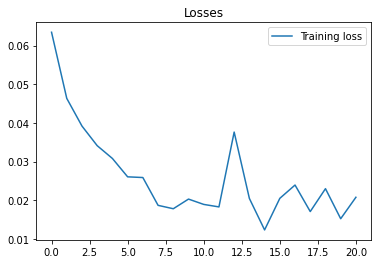

In [256]:
plt.plot(train_losses, label="Training loss")
plt.legend()
plt.title("Losses")

In [257]:
test_losses = []

for epoch in range(0,101):
    
    test_loss = 0 
    correct = 0
    ffnn.eval()

    for x_batch, y_batch, batch in generate_batch_data(test_features, test_labels, batch_size):
        y_pred = ffnn(x_batch)
        loss = criterion(y_pred, y_batch.long())
        pred = np.argmax(y_pred.data,axis=1)
        test_loss += loss.item()
        correct += pred.eq(y_batch.data).sum()

    if epoch % 5 == 0:
      test_losses.append(test_loss/len(test_features))

      print(f"{epoch} / 100 | loss = {test_loss/len(test_features)} | Accuracy = {100. * correct/len(test_features)}%")

0 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
5 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
10 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
15 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
20 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
25 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
30 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
35 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
40 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
45 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
50 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
55 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
60 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
65 / 100 | loss = 0.1909887397196144 | Accuracy = 66.66666412353516%
70 / 100 | loss = 0.1909887397196144

In [259]:
classifier = NeuralNetClassifier(module= ffnn, criterion= nn.CrossEntropyLoss, max_epochs = 100)
scores = cross_val_score(classifier, cls_features, y.astype(int), cv=7, scoring = "accuracy")

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9735       0.8321        0.5085  0.0285
      2        0.8166       0.8550        0.4797  0.0282
      3        0.7450       0.8550        0.4710  0.0259
      4        0.6957       0.8550        0.4653  0.0262
      5        0.6539       0.8397        0.4619  0.0274
      6        0.6174       0.8397        0.4604  0.0272
      7        0.5852       0.8321        0.4606  0.0276
      8        0.5566       0.8321        0.4618  0.0268
      9        0.5310       0.8397        0.4639  0.0327
     10        0.5079       0.8397        0.4667  0.0279
     11        0.4870       0.8397        0.4699  0.0268
     12        0.4680       0.8397        0.4733  0.0260
     13        0.4510       0.8321        0.4765  0.0265
     14        0.4358       0.8321        0.4792  0.0269
     15        0.4224       0.8321        0.4815  0.0263
     16        0.4105       0.8